In [2]:
import pandas as pd
import numpy as np
from plot_cdf import plot_cdf, plot_cdf_multiple
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import glob
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from conf_dict_util import conf_to_dict, dict_to_conf
from qoe_utils import make_bandwidth_series, get_QoE_rr, get_QoE_delay, get_QoE_losses, get_reward

In [3]:
traces = [
'WIRED_200kbps',
'WIRED_900kbps',
'WIRED_35mbps',
'4G_500kbps',
'4G_700kbps',
'4G_3mbps',
'5G_12mbps',
'5G_13mbps',
'trace_300k'
]

In [4]:
from best_algs import best_models_dict
list_conf_names = [d[200] for d in best_models_dict.values()]
print("Len list_conf_names: ", len(list_conf_names))

Len list_conf_names:  9


In [5]:
plot_rr = False
plot_delay = False

prefix = "../output/rates_delay_loss_test_"
suffix = ".pickle"
result_qoe = []


for conf_name in list_conf_names:
    
    d = conf_to_dict(conf_name)
    
    print("Input model: ", conf_name, " trained on trace: ", d["trace_name"])

    time_step = d["step_time"]
    reward_profile = d["reward_profile"]
    delay_states = d["delay_states"]
    normalize_states = d["normalize_states"]
    alg_name = d["alg"]

    name = d["trace_name"]

    #Read rates_delay_loss and make l_rate
    pickle_path = prefix+conf_name+suffix
    if not os.path.exists(pickle_path):
        print("Conf doesn't exist: ", conf_name)
        print("--------------------------")
        continue
    
    dict_result = {}
    dict_result["trained_on_trace"] = d["trace_name"]
    
    l_rate = pd.read_pickle(pickle_path)
    
    for trace in traces:
        
        dict_result[trace] = {}
    
        #Read the same for GCC
        pickle_path_gcc = f"../apply_model/results_gcc/rates_delay_loss_gcc_{trace}.pickle"
        l_rate_gcc = pd.read_pickle(pickle_path_gcc)
        trace_name = l_rate_gcc["trace_name"]
        if trace_name != trace:
            print("Does not coincide with GCC pickle!")
        
    
        #QoE rr
        U, U_gcc = get_QoE_rr(l_rate, l_rate_gcc, trace, time_step, test=True)
        qoe_rr = 100*U.quantile(0.5)
        qoe_rr_gcc = 100*U_gcc.quantile(0.5)
        # print("QoE rr:", f"RL: {round(qoe_rr,2)}, GCC: {round(qoe_rr_gcc,2)}")
        if plot_rr:
            plot_cdf_multiple([U, U_gcc], "bandwidth_util", legend=["RL", "GCC"], figsize=(4,2))
            plt.show()

        dict_result[trace]["qoe_rr"] = qoe_rr
        # dict_result[trace]["qoe_rr_gcc"] = qoe_rr_gcc

        #QoE delay
        delay, delay_gcc, qoe_delay, qoe_delay_gcc = get_QoE_delay(l_rate, l_rate_gcc, trace, time_step, test=True)
        # print("QoE delay:", f"RL: {round(qoe_delay,2)}, GCC: {round(qoe_delay_gcc,2)}")
        if plot_delay:
            plot_cdf_multiple([delay, delay_gcc], "delay", legend=["RL", "GCC"], figsize=(4,2))
            plt.xlim(0,1000)
            plt.show()

        dict_result[trace]["qoe_delay"] = qoe_delay
        # dict_result[trace]["qoe_delay_gcc"] = qoe_delay_gcc

        #QoE losses
        loss_ratio, loss_ratio_gcc, qoe_losses, qoe_losses_gcc = get_QoE_losses(l_rate, l_rate_gcc, trace, time_step, test=True)
        # print("QoE loss:", f"RL: {round(qoe_losses,2)}, GCC: {round(qoe_losses_gcc,2)}")

        dict_result[trace]["qoe_losses"] = round(qoe_losses,2)
        # dict_result[trace]["qoe_losses_gcc"] = round(qoe_losses_gcc,2)

        #Overall QoE
        qoe = 0.333*qoe_rr + 0.333*qoe_delay + 0.333*qoe_losses
        qoe_gcc = 0.333*qoe_rr_gcc + 0.333*qoe_delay_gcc + 0.333*qoe_losses_gcc

        dict_result[trace]["qoe"] = qoe
        # dict_result[trace]["qoe_gcc"] = qoe_gcc

        print(f"Overall QoE for trained on {name}, tested on {trace}:", f"RL: {round(qoe,2)}, GCC: {round(qoe_gcc,2)}")
        print("---------")
        
        cum_reward, avg_reward = get_reward(l_rate, trace, test=True)

        dict_result[trace]["cum_reward"] = cum_reward
        dict_result[trace]["avg_reward"] = avg_reward

    result_qoe.append(dict_result)
    


Input model:  SAC_WIRED_900kbps_200_delay_True_norm_states_True_tuned_True_reward_profile_0_seed_22  trained on trace:  WIRED_900kbps
Overall QoE for trained on WIRED_900kbps, tested on WIRED_200kbps: RL: 71.96, GCC: 91.99
---------
Overall QoE for trained on WIRED_900kbps, tested on WIRED_900kbps: RL: 86.47, GCC: 77.03
---------
Overall QoE for trained on WIRED_900kbps, tested on WIRED_35mbps: RL: 58.17, GCC: 58.16
---------
Overall QoE for trained on WIRED_900kbps, tested on 4G_500kbps: RL: 74.65, GCC: 84.88
---------
Overall QoE for trained on WIRED_900kbps, tested on 4G_700kbps: RL: 89.57, GCC: 83.04
---------
Overall QoE for trained on WIRED_900kbps, tested on 4G_3mbps: RL: 72.05, GCC: 65.43
---------
Overall QoE for trained on WIRED_900kbps, tested on 5G_12mbps: RL: 60.01, GCC: 63.07
---------
Overall QoE for trained on WIRED_900kbps, tested on 5G_13mbps: RL: 49.72, GCC: 53.62
---------
Overall QoE for trained on WIRED_900kbps, tested on trace_300k: RL: 58.61, GCC: 69.83
--------

In [6]:
df = pd.DataFrame(result_qoe).set_index("trained_on_trace")
df = df[df.index]
df_qoe = df.applymap(lambda x: x["qoe"])
df_qoe_rr = df.applymap(lambda x: x["qoe_rr"])
df_qoe_delay = df.applymap(lambda x: x["qoe_delay"])
df_qoe_loss = df.applymap(lambda x: x["qoe_losses"])
df_avg_reward = df.applymap(lambda x: x["avg_reward"])
df_cum_reward = df.applymap(lambda x: x["cum_reward"])

In [7]:
df

,WIRED_900kbps,WIRED_200kbps,WIRED_35mbps,4G_700kbps,4G_3mbps,4G_500kbps,5G_12mbps,5G_13mbps,trace_300k
trained_on_trace,,,,,,,,,
WIRED_900kbps,"{'qoe_rr': 75.88193624557262, 'qoe_delay': 83....","{'qoe_rr': 100.0, 'qoe_delay': 49.286443293836...","{'qoe_rr': 1.9931563421828908, 'qoe_delay': 73...","{'qoe_rr': 92.4896648457109, 'qoe_delay': 78.2...","{'qoe_rr': 43.43589743589744, 'qoe_delay': 84....","{'qoe_rr': 99.62678609511624, 'qoe_delay': 48....","{'qoe_rr': 5.136608743369306, 'qoe_delay': 75....","{'qoe_rr': 5.252540952380952, 'qoe_delay': 44....","{'qoe_rr': 100.0, 'qoe_delay': 0.4910988336402..."
WIRED_200kbps,"{'qoe_rr': 21.882903981264636, 'qoe_delay': 26...","{'qoe_rr': 85.6045197740113, 'qoe_delay': 98.0...","{'qoe_rr': 0.5801183431952663, 'qoe_delay': 63...","{'qoe_rr': 28.949669439112814, 'qoe_delay': 92...","{'qoe_rr': 7.576865671641792, 'qoe_delay': 93....","{'qoe_rr': 36.340371081254, 'qoe_delay': 92.53...","{'qoe_rr': 1.513125, 'qoe_delay': 51.134967736...","{'qoe_rr': 1.4550659668038022, 'qoe_delay': 49...","{'qoe_rr': 56.080000000000005, 'qoe_delay': 0...."
WIRED_35mbps,"{'qoe_rr': 98.51288343558282, 'qoe_delay': 10....","{'qoe_rr': 100.0, 'qoe_delay': 47.741139302991...","{'qoe_rr': 20.522474226804125, 'qoe_delay': 66...","{'qoe_rr': 100.0, 'qoe_delay': 14.614381775765...","{'qoe_rr': 99.23875, 'qoe_delay': 37.510074282...","{'qoe_rr': 100.0, 'qoe_delay': 12.650770721499...","{'qoe_rr': 50.66151898734177, 'qoe_delay': 72....","{'qoe_rr': 41.717666250668564, 'qoe_delay': 38...","{'qoe_rr': 100.0, 'qoe_delay': 0.0659811953593..."
4G_700kbps,"{'qoe_rr': 82.3177570093458, 'qoe_delay': 63.1...","{'qoe_rr': 95.86666666666666, 'qoe_delay': 93....","{'qoe_rr': 3.2630088495575222, 'qoe_delay': 71...","{'qoe_rr': 72.79643847302198, 'qoe_delay': 86....","{'qoe_rr': 18.517777777777777, 'qoe_delay': 84...","{'qoe_rr': 78.21497120921305, 'qoe_delay': 88....","{'qoe_rr': 7.269772632457238, 'qoe_delay': 61....","{'qoe_rr': 7.149379684673043, 'qoe_delay': 47....","{'qoe_rr': 74.41333333333333, 'qoe_delay': 18...."
4G_3mbps,"{'qoe_rr': 3.549295774647887, 'qoe_delay': 67....","{'qoe_rr': 16.615384615384617, 'qoe_delay': 99...","{'qoe_rr': 1.643478260869565, 'qoe_delay': 49....","{'qoe_rr': 4.5345489443378115, 'qoe_delay': 94...","{'qoe_rr': 81.9125, 'qoe_delay': 91.0652554341...","{'qoe_rr': 6.5111472021260886, 'qoe_delay': 95...","{'qoe_rr': 0.24387096774193548, 'qoe_delay': 4...","{'qoe_rr': 19.579428244711263, 'qoe_delay': 43...","{'qoe_rr': 10.08, 'qoe_delay': 80.0, 'qoe_loss..."
4G_500kbps,"{'qoe_rr': 50.74418604651163, 'qoe_delay': 95....","{'qoe_rr': 86.37037037037038, 'qoe_delay': 86....","{'qoe_rr': 1.3175366568914957, 'qoe_delay': 69...","{'qoe_rr': 58.850220560999425, 'qoe_delay': 95...","{'qoe_rr': 15.661194029850748, 'qoe_delay': 88...","{'qoe_rr': 69.98080614203455, 'qoe_delay': 91....","{'qoe_rr': 3.2122044453989043, 'qoe_delay': 60...","{'qoe_rr': 3.0983107672469377, 'qoe_delay': 58...","{'qoe_rr': 90.68, 'qoe_delay': 90.627495185759..."
5G_12mbps,"{'qoe_rr': 98.52927400468384, 'qoe_delay': 5.3...","{'qoe_rr': 100.0, 'qoe_delay': 47.461925629147...","{'qoe_rr': 22.224000000000004, 'qoe_delay': 72...","{'qoe_rr': 98.27624390964121, 'qoe_delay': 63....","{'qoe_rr': 100.0, 'qoe_delay': 87.661606706209...","{'qoe_rr': 99.2654658201683, 'qoe_delay': 47.9...","{'qoe_rr': 55.947957009433516, 'qoe_delay': 72...","{'qoe_rr': 50.49937106918239, 'qoe_delay': 54....","{'qoe_rr': 100.0, 'qoe_delay': 0.5608229104487..."
5G_13mbps,"{'qoe_rr': 98.39755351681957, 'qoe_delay': 8.6...","{'qoe_rr': 100.0, 'qoe_delay': 47.453772704194...","{'qoe_rr': 16.31693215339233, 'qoe_delay': 67....","{'qoe_rr': 99.12151188542744, 'qoe_delay': 15....","{'qoe_rr': 97.915, 'qoe_delay': 89.44179716200...","{'qoe_rr': 99.88603646833013, 'qoe_delay': 12....","{'qoe_rr': 40.889192690261396, 'qoe_delay': 68...","{'qoe_rr': 40.53868844296171, 'qoe_delay': 61....","{'qoe_rr': 100.0, 'qoe_delay': 0.1989829759009..."
trace_300k,"{'qoe_rr': 30.06031363

### Heatmap of average reward

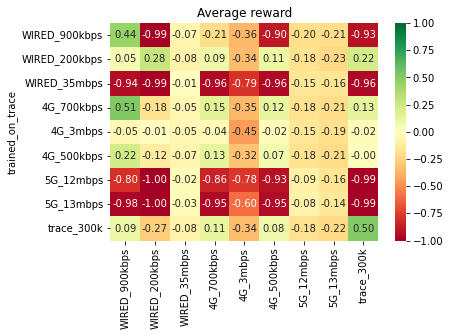

In [8]:
ax = sns.heatmap(df_avg_reward ,cmap="RdYlGn", vmin=-1, vmax=1, annot=True, fmt=".2f")
a = plt.title("Average reward")

In [9]:
# ax = sns.heatmap(df_cum_reward ,cmap="RdYlGn", vmin=-300, vmax=300)

### Heatmap of overall QoE

In [10]:
df_qoe.mean(axis=1)

trained_on_trace
WIRED_900kbps    69.023409
WIRED_200kbps    62.641250
WIRED_35mbps     52.046229
4G_700kbps       71.767518
4G_3mbps         62.628202
4G_500kbps       74.076188
5G_12mbps        66.847349
5G_13mbps        54.758422
trace_300k       68.951298
dtype: float64

In [11]:
(86+72+58+90+72+75+60+50+59)/9

69.11111111111111

In [13]:
df_qoe.min()

WIRED_900kbps    40.208220
WIRED_200kbps    50.604150
WIRED_35mbps     50.157992
4G_700kbps       41.485310
4G_3mbps         62.552354
4G_500kbps       40.362601
5G_12mbps        49.551044
5G_13mbps        47.758849
trace_300k       36.925784
dtype: float64

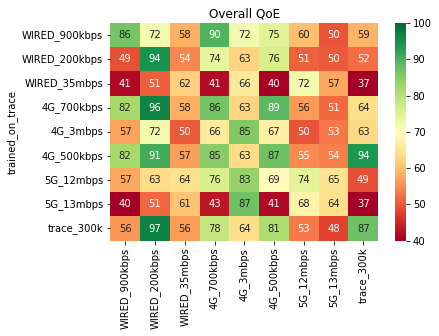

In [14]:
ax = sns.heatmap(df_qoe ,cmap="RdYlGn", vmin=40, vmax=100, annot=True)
a = plt.title("Overall QoE")

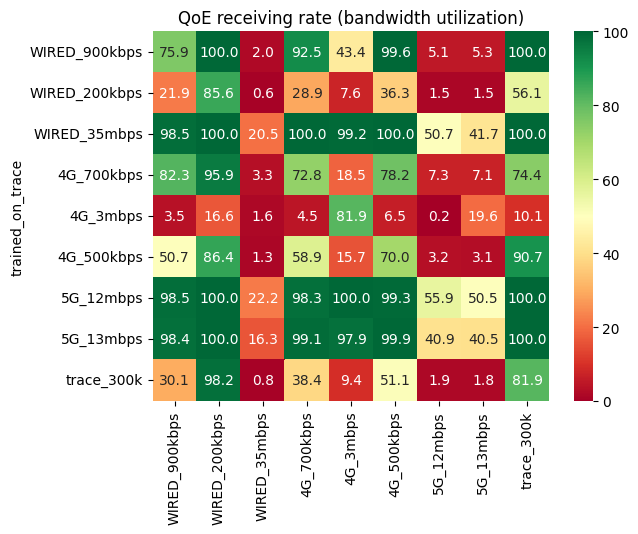

In [24]:
ax = sns.heatmap(df_qoe_rr ,cmap="RdYlGn", vmin=0, vmax=100, annot=True, fmt=".1f")
a = plt.title("QoE receiving rate (bandwidth utilization)")

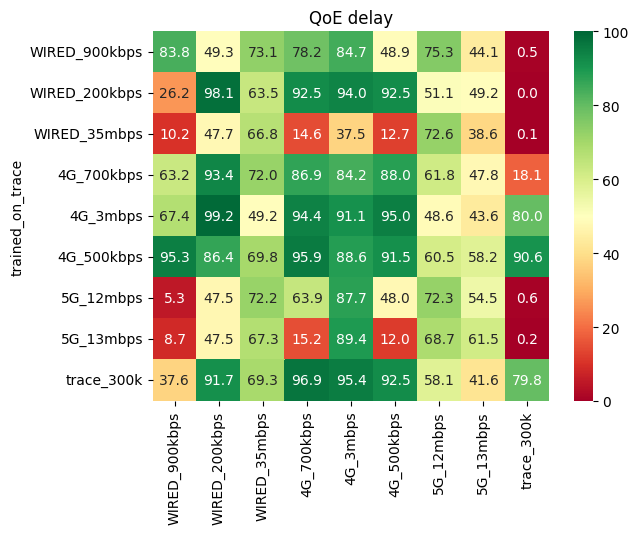

In [25]:
ax = sns.heatmap(df_qoe_delay ,cmap="RdYlGn", vmin=0, vmax=100, annot=True, fmt=".1f")
a = plt.title("QoE delay")

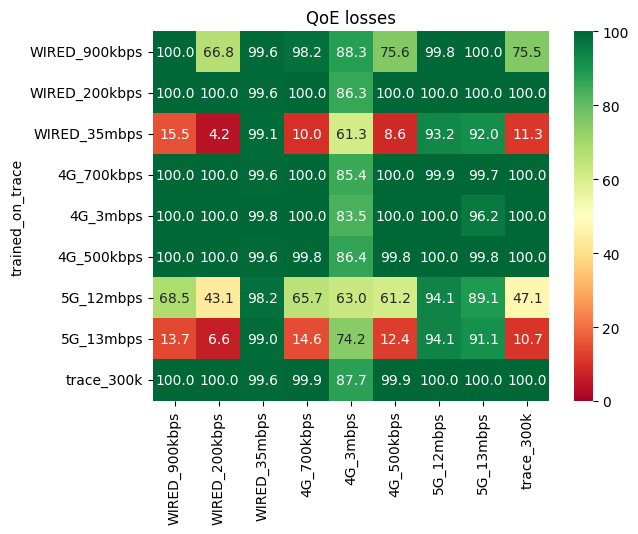

In [26]:
ax = sns.heatmap(df_qoe_loss ,cmap="RdYlGn", vmin=0, vmax=100, annot=True, fmt=".1f")
a = plt.title("QoE losses")